# Mechanistic models of KRP4 dependent cell-size control (D'Ario et al., 2021)

## KRP4 dynamics in G2 phase of the cell cycle (an ODE model)

The article describes an ODE model that is used to capture the dynamics of the KRP4 protein in the nucleus, during the G2 phase of the cell cycle. The model equations are as follows. 

\begin{align}
\frac{dN_{kc}}{dt}&= \beta\frac{N_kN_c}{V} - \gamma N_{kc} \\
\frac{dN_{c}}{dt}&= -\beta\frac{N_kN_c}{V} + \gamma N_{kc} \\
\frac{dN_{k}}{dt}&= -\beta\frac{N_kN_c}{V} + \gamma N_{kc} + \phi V - \mu N_k
\end{align}

Here $N_{kc}$ is the number of molecules of chromatin bound KRP4, $N_{c}$ is the number of free chromatin sites for KRP4 binding, and $N_{kc}$ is the number of molecules of free KRP4

**Exercise 1**: On the sheet provided, for each of the arrows in the model schematic, write down the process they represent

**Exercise 2**: On the sheet provided, can you map each process represented in the schematic to the corresponding term in the equations that describes the contribution from this process?

**Exercise 3**: On the sheet provided, for each of the processes described by the model, write down the parameter ($\beta$, $\gamma$, $\phi$, or $\mu$) that corresponds to this process

**Exercise 4**: On the sheet provided, write down what you think are the main assumptions made in constructing this model

**Assumption:** In this model, the nucleus volume V is assumed to increase over time during the G2 phase, at a rate that is independent of KRP4 levels.The volume $V$ at time $t$ is described by the following equation:

\begin{equation}
V = V_2g_2^t 
\end{equation}

where $g_2$ is the relative growth rate and $V_2$ is the initial nucleus volume at the start of G2 phase. Although V is changing with time, here we don't have an equation describing the time derivative of V. Instead we have something that's even simpler to use: an equation where we can just plug in the time to compute the corresponding volume. Thus, the volume V can be treated as a parameter in the ODE model -  a parameter that is itself changing with time.

Let's use this equation to plot the change in volume during G2 phase over time:

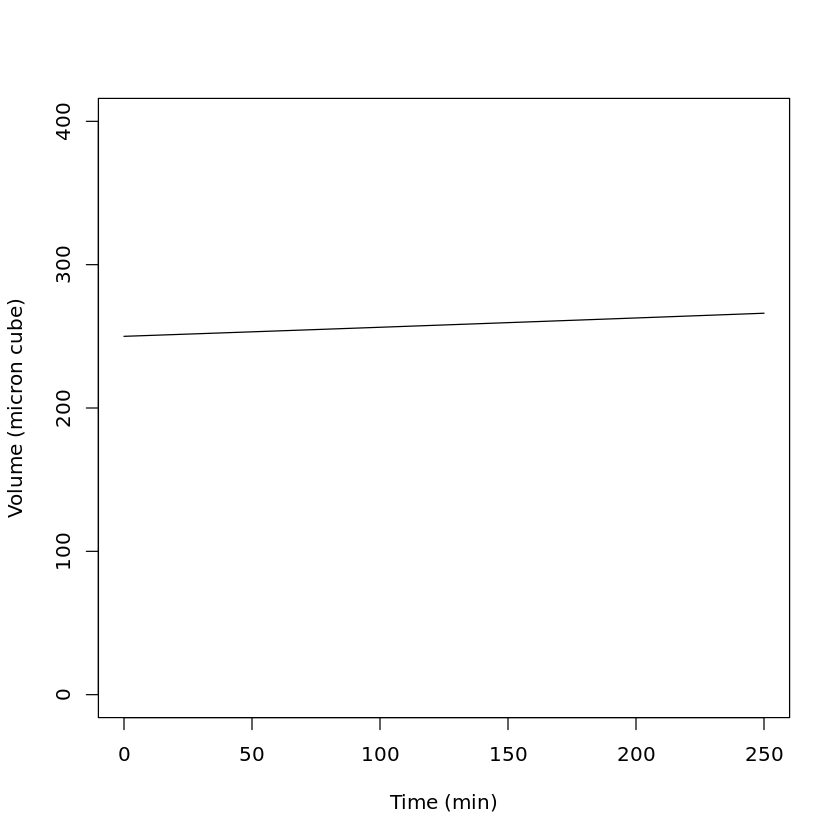

In [2]:
t=seq(0,250,1)  # Specify timepoints at which we want to evaluate V
g2 = 1.00025     # Specify the value of the relative growth rate g2
V = (g2^t)*250  # Compute the nuclear volume V at the specified timepoints using the equation given above


plot(t,V, type="l", xlim=c(0,250), ylim=c(0,400), xlab="Time (min)", ylab="Volume (micron cube)")

We can see that the volume increase is really quite slow. Now let's try solving the ODE model equations using R. 

We begin by loading the deSolve library:

In [7]:
install.packages("deSolve") #If the package needs to be installed. If it's already installed you will get a warning - ignore it.
library("deSolve") #This is the library we will use to solve the equations


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



Next we specify the model equations inside an R function:

In [6]:
KRP_func<-function(t,state,parameters){
  with(as.list(c(state, parameters)),{
  if (t<=120){
    gamma=gamma_upto_120min
  } else {
    gamma=gamma_after_120min
  }
  V = (g2^t)*V2  # Compute volume at current timepoint
  
  dNkcdt = beta*Nk*Nc/V - gamma*Nkc # Equation for rate of change of Nkc
  dNcdt = gamma*Nkc - beta*Nk*Nc/V  # Equation for rate of change of Nc
  dNkdt = gamma*Nkc - beta*Nk*Nc/V + phi*V - mu*Nk # Equation for rate of change of Nk
  
  list(c(dNkcdt,dNcdt,dNkdt))  #Function returns a list of computed rates of change
  })
}

Note how we have put the equation for computing volume inside our function.

Then we specify the list of initial conditions and the list of parameter values:

In [8]:
# List of Initial conditions
state <-c(Nkc = 100,
          Nc = 100,
          Nk = 100
)

# List of Parameter values

parameters <- c(
  beta =1.5,   # this is parameter beta
  gamma_upto_120min = 1,   # this is parameter gamma upto 120min
  gamma_after_120min = 1, # this is parameter gamma after 120min
  phi = 0.4,      # this is parameter phi
  mu = 0.8,  # this is parameter mu
  g2 = 1.00025, # this is the relative growth rate in G2 phase from article
  V2 = 250 # Starting volume for G2 phase from article
)

And specify timepoints at which we want the solution evaluated:

In [9]:
times=seq(0,250,1) #Creates a vector of timepoints (minutes) at which the solution will be evaluated

Finally, we pass the function containing our model equations, along with the lists of initial conditions and parameter values to the `ode` function from the `deSolve` library:

In [10]:
sol=ode(state,times,KRP_func,parameters)

Running the above cell generates the numerical solution we want. The solution generated by the `ode` function is essentially a four column table, with our specified times as the first column, and the values of the three variables $N_{kc}$, $N_c$ and $N_k$ as the next three columns. This table is stored under the name `sol`. We can now extract these values from the table to plot the solution, and see how KRP4 levels are predicted to change over time:

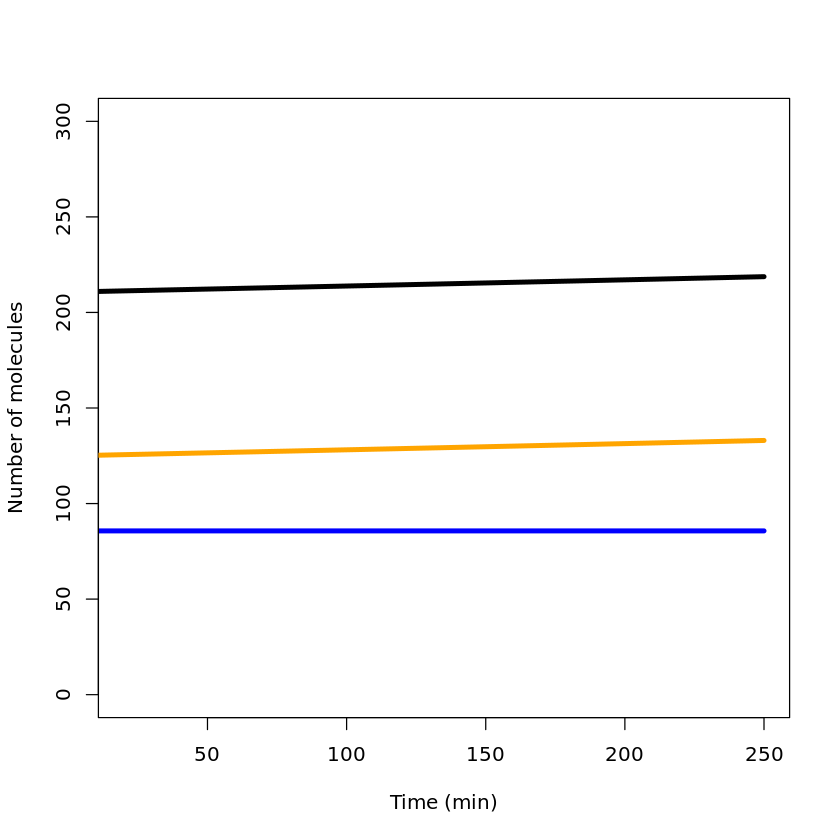

In [11]:
Nkc <- sol[,2] # Column 2 contains the values of Nkc
Nc <- sol[,3]  # Column 3 contains the values of Nc
Nk <- sol[,4]  # Column 4 contains the values of Nk
Total_KRP <- Nk + Nkc

plot(times,Nkc, type="l", lwd=4,col="blue", xlim=c(20,250), ylim=c(0,300), xlab="Time (min)", ylab="Number of molecules")
lines(times,Nk, col="orange",lwd=4)
#lines(times,Nc, col="red",lwd=4)
lines(times,Total_KRP, col="black",lwd=4)

**Exercise 5**: By changing the parameter values for $\beta$, $\gamma$, $\phi$, and $\mu$ set above, try to recreate the solutions shown in the article (Figure 4(C)). The parameter values used to solve these equations are given in the article - can you find them?

**Exercise 6**: Now let's see what the model predicts if the growth rate is higher, i.e. the nucleus volume V increases faster. Increase the value parameter `g2` above by a factor of 10 and plot the resulting solution. Do you see a clear difference in the solution curves? Which of the curves looks unchanged by the increased rate of volume change? Can you see why this happens? ***Hint:*** Looking back at the model assumptions, would a change in nuclear volume affect the number of sites available for KRP4 to bind on chromatin? 

**Bonus Exercise**: The model prediction highlighted in the article is that a decreased dissociation of KRP4 from chromatin (i.e. a decrease in the parameter $\gamma$) would cause an increase in total KRP4 levels in G2 phase. But this is not the only change that can produce an increase in total KRP4 levels in G2 phase. What if the KRP4 degradation rate is reduced instead (i.e. a decrease in the parameter $\mu$) while the dissociation is unaffected? 

Let's modify our function to explore this possibility:

In [3]:
KRP_func<-function(t,state,parameters){
  with(as.list(c(state, parameters)),{
  # WE FIRST COMMENT OUT THE LINES SPECIFYING A CHANGE IN gamma AT 120min    
  # if (t<=120){
  #   gamma=gamma_upto_120min
  # } else {
  #   gamma=gamma_after_120min
  # }
    
  # THEN WE ADD THE FOLLOWING LINES SPECIFYING A CHANGE IN mu AT 120min
    if (t<=120){
      mu=mu_upto_120min
    } else {
      mu=mu_after_120min
    }
      
  # THE REST IS THE SAME AS BEFORE
  V = (g2^t)*V2  
  
  dNkcdt = beta*Nk*Nc/V - gamma*Nkc
  dNcdt = gamma*Nkc - beta*Nk*Nc/V
  dNkdt = gamma*Nkc - beta*Nk*Nc/V + phi*V - mu*Nk
  
  list(c(dNkcdt,dNcdt,dNkdt))
  })
}


Next we set the initial conditions and parameters as before. But this time we specify different values of the parameter `mu` upto and after the 120min timepoint. In the cell below, set these values to 0.5 upto 120min and 0.2 after 120min.

In [5]:
# List of Initial conditions
state <-c(Nkc = 100,
          Nc = 100,
          Nk = 100
)

# List of Parameter values
parameters <- c(
  beta =1,   # this is parameter beta
  mu_upto_120min = 0.5,   # this is parameter gamma upto 120min
  mu_after_120min = 0.5, # this is parameter gamma after 120min
  phi = 0.1,      # this is parameter phi
  gamma = 1,  # this is parameter mu
  g2 = 1.00025, # this is the relative growth rate in G2 phase
  V2 = 250 # Starting volume
)

We can now solve the modified model and plot the solutions exactly as before.

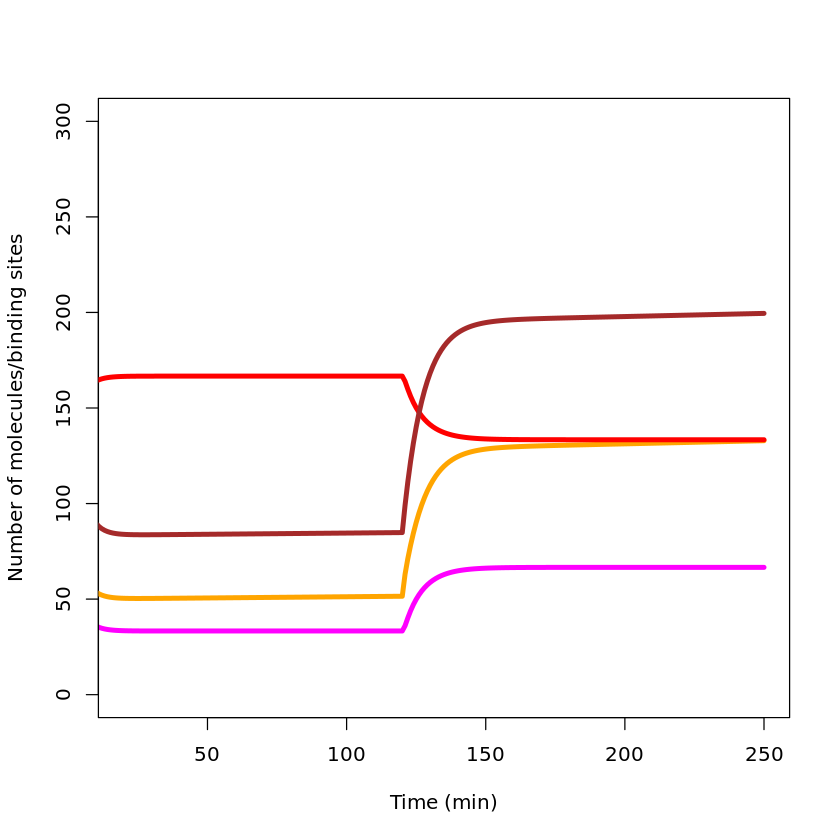

In [6]:
times=seq(0,250,1) #Creates a vector of timepoints (minutes) at which the solution will be evaluated
sol=ode(state,times,KRP_func,parameters)
Nkc <- sol[,2]
Nc <- sol[,3]
Nk <- sol[,4]
Total_KRP <- Nk + Nkc

plot(sol[,1],Nkc, type="l", lwd=4,col="magenta", xlim=c(20,250), ylim=c(0,300), xlab="Time (min)", ylab="Number of molecules/binding sites")
lines(sol[,1],Nk, col="orange",lwd=4)
lines(sol[,1],Nc, col="red",lwd=4)
lines(sol[,1],Total_KRP, col="brown",lwd=4)

Can you spot any obvious differences to what we saw earlier? Which solution curve do you think shows the clearest "qualitative" difference? Why do you think this is? ***Hint:*** Go back to the model equations and set all the derivatives to zero (steady state). What is special about $N_k$ (number of molecules of free KRP)?

**Answer:**